Data : https://universe.roboflow.com/search?q=chess%20pieces

# Install Detectron2 Dependencies

In [1]:
!pip install pyyaml==5.1

import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
# !pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
# If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'
# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 4.7 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
torch:  2.5 ; cuda:  cu121
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-a8vvcsfx
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-a8vvcsfx
  Resolved https://github.com/facebookresearch/detectron2.git to commit 9604f5995cc628619f0e4fd913453b4d7d61db3f
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━

In [2]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
# Import PyTorch transforms
import torchvision.transforms as T
from PIL import Image
from datetime import datetime
import shutil
from detectron2.data.datasets import register_coco_instances

# Import and Register Custom Detectron2 Data

In [ ]:
!curl -L  https://www.kaggle.com/api/v1/datasets/download/pythonafroz/solar-panel-images > solar-panel.zip; unzip solar-panel.zip; rm solar-panel.zip



Entire frame previous Approach:
```python
# Old approach simply used the full image bounds
bbox = [0, 0, self.image_size[0], self.image_size[1]]
```

This was problematic because it treated every image as if the defect occupied the entire frame. In reality, solar panel defects are often localized to specific regions. Let's examine the improved approach:

```python
def compute_defect_bbox(self, image):
    # Convert to grayscale for more robust processing
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Apply adaptive thresholding
    thresh = cv2.adaptiveThreshold(
        gray, 255,                    # Maximum value
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,  # Gaussian-weighted sum of neighborhood
        cv2.THRESH_BINARY_INV,          # Inverse binary threshold
        11,                             # Size of pixel neighborhood
        2                               # Constant subtracted from mean
    )
    
    # Find contours of potential defects
    contours, _ = cv2.findContours(
        thresh,
        cv2.RETR_EXTERNAL,     # Only retrieve the extreme outer contours
        cv2.CHAIN_APPROX_SIMPLE  # Compress horizontal, vertical, diagonal segments
    )
```

The improvements here are significant:

1. Adaptive Thresholding:
   - Instead of using a fixed threshold, we use a Gaussian-weighted neighborhood
   - This adapts to local lighting variations in the image
   - The 11x11 pixel neighborhood provides a good balance between local detail and noise reduction
   - The constant value of 2 helps reduce false positives from minor variations

2. Contour Detection:
   - We find actual shapes in the image rather than assuming the whole image is a defect
   - RETR_EXTERNAL ensures we get the outermost boundaries of defects
   - CHAIN_APPROX_SIMPLE reduces memory usage while maintaining accuracy

Now, let's examine how we handle transformations with our improved `transform_bbox`:

Previous Approach:
```python
# Old approach didn't handle transformations at all
# Bounding boxes would become invalid after augmentation
```

New approach:
```python
def transform_bbox(self, bbox, transform_params):
    x, y, w, h = bbox
    
    if transform_params.get('flip', False):
        # Handle horizontal flips by mirroring x-coordinate
        x = self.image_size[0] - (x + w)
    
    if 'rotate' in transform_params:
        # Create rotation matrix around image center
        angle = transform_params['rotate']
        center = (self.image_size[0] / 2, self.image_size[1] / 2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        
        # Transform all four corners of the bbox
        points = np.array([
            [x, y],           # Top-left
            [x + w, y],       # Top-right
            [x, y + h],       # Bottom-left
            [x + w, y + h],   # Bottom-right
        ]).T
```

The key improvements in transformation handling are:

1. Geometric Awareness:
   - We track all four corners of the bounding box during transformations
   - This preserves the spatial relationship between the defect and its annotation
   - The rotation matrix properly handles angle transformations around the image center

2. Boundary Enforcement:
```python
# Ensure bbox stays within image bounds
x = max(0, min(x, self.image_size[0] - w))
y = max(0, min(y, self.image_size[1] - h))
w = min(w, self.image_size[0] - x)
h = min(h, self.image_size[1] - y)
```

This ensures that:
- Bounding boxes never extend outside the image
- Dimensions remain positive and valid
- Spatial relationships are preserved

To visualize the improvement, consider a solar panel with a bird dropping:

1. Previous approach would mark the entire image as the defect area
2. New approach:
   - Detect the actual area of the bird dropping using adaptive thresholding
   - Create a tight bounding box around just the affected area
   - Maintain this precise localization through any augmentations
   - Adjust the bounding box coordinates appropriately for flips and rotations



In [8]:
# Import required libraries
import os
import json
import shutil
import uuid
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from datetime import datetime
import matplotlib.pyplot as plt
import cv2
import random
from detectron2.data.datasets import register_coco_instances
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.utils.visualizer import Visualizer

class EnhancedDirectoryToCOCO:
    def __init__(self, source_dir, output_base_dir, image_size=(224, 224)):
            """
            Initialize the Enhanced Directory to COCO converter

            Args:
                source_dir: Source directory containing class folders
                output_base_dir: Base directory for output
                image_size: Tuple of (width, height) for resizing
            """
            self.source_dir = os.path.abspath(source_dir)
            self.output_base_dir = os.path.abspath(output_base_dir)
            self.train_dir = os.path.join(self.output_base_dir, 'train')
            self.test_dir = os.path.join(self.output_base_dir, 'test')
            self.image_size = image_size
            self.id_mapper = {}  # Track original to augmented image mappings

            # Create output directories
            for dir_path in [self.train_dir, self.test_dir]:
                os.makedirs(dir_path, exist_ok=True)

            # Define PyTorch augmentations
            self.augmentation_transforms = T.Compose([
                T.RandomHorizontalFlip(p=0.5),
                T.RandomRotation(20),
                T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                T.RandomResizedCrop(size=image_size, scale=(0.8, 1.0)),
            ])

    def generate_unique_id(self):
        """Generate a unique ID for images and annotations"""
        return str(uuid.uuid4())
    def compute_defect_bbox(self, image):
        """
        Compute bounding box for defect region using computer vision

        Args:
            image: numpy array of the image
        Returns:
            list: [x, y, width, height] of the bounding box
        """
        try:
            # Convert to grayscale
            gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

            # Apply adaptive thresholding
            thresh = cv2.adaptiveThreshold(
                gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                cv2.THRESH_BINARY_INV, 11, 2
            )

            # Find contours
            contours, _ = cv2.findContours(
                thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
            )

            if contours:
                # Find the largest contour
                largest_contour = max(contours, key=cv2.contourArea)
                x, y, w, h = cv2.boundingRect(largest_contour)

                # Validate bbox dimensions
                if w > 0 and h > 0 and w <= self.image_size[0] and h <= self.image_size[1]:
                    return [x, y, w, h]

            # Fallback to full image if no valid contours found
            return [0, 0, self.image_size[0], self.image_size[1]]

        except Exception as e:
            print(f"Error in compute_defect_bbox: {str(e)}")
            return [0, 0, self.image_size[0], self.image_size[1]]

    def transform_bbox(self, bbox, transform_params):
        """
        Transform bounding box according to augmentation parameters

        Args:
            bbox: Original bounding box [x, y, w, h]
            transform_params: Dictionary of transformation parameters
        Returns:
            list: Transformed bounding box
        """
        try:
            x, y, w, h = bbox

            # Apply transforms based on augmentation parameters
            if transform_params.get('flip', False):
                x = self.image_size[0] - (x + w)

            if 'rotate' in transform_params:
                # Handle rotation transformation
                angle = transform_params['rotate']
                center = (self.image_size[0] / 2, self.image_size[1] / 2)
                M = cv2.getRotationMatrix2D(center, angle, 1.0)

                # Transform bbox corners
                points = np.array([
                    [x, y],
                    [x + w, y],
                    [x, y + h],
                    [x + w, y + h],
                ]).T
                ones = np.ones(shape=(1, points.shape[1]))
                points_ones = np.vstack([points, ones])
                transformed_points = M @ points_ones

                # Get new bbox coordinates
                x_coords = transformed_points[0, :]
                y_coords = transformed_points[1, :]
                x = min(x_coords)
                y = min(y_coords)
                w = max(x_coords) - x
                h = max(y_coords) - y

            # Ensure bbox stays within image bounds
            x = max(0, min(x, self.image_size[0] - w))
            y = max(0, min(y, self.image_size[1] - h))
            w = min(w, self.image_size[0] - x)
            h = min(h, self.image_size[1] - y)

            return [x, y, w, h]

        except Exception as e:
            print(f"Error in transform_bbox: {str(e)}")
            return bbox



    def create_coco_annotation(self, image_files, split_name, augment=True):
        """
        Create COCO format annotations with augmentation

        Args:
            image_files: List of (image_path, class_name) tuples
            split_name: Name of the split ('train' or 'test')
            augment: Whether to apply augmentation
        Returns:
            tuple: (coco_format dict, successful_conversions list)
        """
        coco_format = {
            "info": {
                "year": datetime.now().year,
                "version": "1.0",
                "description": "Solar Panel Defect Detection Dataset",
                "contributor": "Enhanced Detectron2 Dataset",
                "date_created": datetime.now().strftime("%Y-%m-%d")
            },
            "images": [],
            "annotations": [],
            "categories": []
        }

        # Create categories
        class_dirs = sorted([d for d in os.listdir(self.source_dir)
                           if os.path.isdir(os.path.join(self.source_dir, d))])

        for cat_id, class_name in enumerate(class_dirs, 1):
            coco_format["categories"].append({
                "id": cat_id,
                "name": class_name,
                "supercategory": "defect"
            })

        cat_id_map = {name: id for id, name in enumerate(class_dirs, 1)}
        successful_conversions = []

        for img_path, class_name in image_files:
            try:
                # Generate unique ID for original image
                original_id = self.generate_unique_id()

                # Read image
                image = cv2.imread(img_path)
                if image is None:
                    print(f"Could not read image: {img_path}")
                    continue

                # Compute original bbox
                original_bbox = self.compute_defect_bbox(image)

                # Convert to PIL for PyTorch transforms
                pil_image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

                # Process original and augmented versions
                versions = [(pil_image, {}, "original")]
                if augment:
                    # Create augmented versions
                    for i in range(2):  # 2 augmented versions
                        aug_image = self.augmentation_transforms(pil_image)
                        transform_params = {
                            'flip': random.random() < 0.5,
                            'rotate': random.uniform(-20, 20)
                        }
                        versions.append((aug_image, transform_params, f"aug_{i}"))

                # Process each version
                for version_idx, (img_version, transform_params, version_type) in enumerate(versions):
                    try:
                        # Generate unique IDs
                        image_id = f"{original_id}_{version_idx}"
                        ann_id = self.generate_unique_id()

                        # Save image
                        img_filename = f"{split_name}_{image_id}.jpg"
                        output_path = os.path.join(
                            self.output_base_dir, split_name, img_filename
                        )
                        img_version.save(output_path, 'JPEG')

                        # Transform bbox if needed
                        bbox = self.transform_bbox(original_bbox, transform_params)

                        # Add image info
                        coco_format["images"].append({
                            "id": image_id,
                            "file_name": img_filename,
                            "width": self.image_size[0],
                            "height": self.image_size[1],
                            "date_captured": datetime.now().strftime("%Y-%m-%d %H:%M:%S")
                        })

                        # Add annotation
                        coco_format["annotations"].append({
                            "id": ann_id,
                            "image_id": image_id,
                            "category_id": cat_id_map[class_name],
                            "bbox": bbox,
                            "area": bbox[2] * bbox[3],
                            "iscrowd": 0
                        })

                        if version_type == "original":
                            successful_conversions.append((img_path, class_name))

                    except Exception as e:
                        print(f"Error processing version {version_type} of {img_path}: {str(e)}")
                        continue

            except Exception as e:
                print(f"Error processing image {img_path}: {str(e)}")
                continue

        return coco_format, successful_conversions
    def validate_annotations(self, coco_format):
        """
        Validate COCO annotations

        Args:
            coco_format: COCO format dictionary
        Returns:
            bool: True if validation passes
        """
        try:
            validation_results = {
                "unique_image_ids": set(),
                "unique_ann_ids": set(),
                "bbox_validity": True,
                "area_consistency": True
            }

            # Validate images
            for img in coco_format["images"]:
                if img["id"] in validation_results["unique_image_ids"]:
                    print(f"Duplicate image ID found: {img['id']}")
                    return False
                validation_results["unique_image_ids"].add(img["id"])

                # Check image file exists
                img_path = os.path.join(
                    self.output_base_dir,
                    img["file_name"].split('_')[0],
                    img["file_name"]
                )
                if not os.path.exists(img_path):
                    print(f"Image file missing: {img_path}")
                    return False

            # Validate annotations
            for ann in coco_format["annotations"]:
                # Check ID uniqueness
                if ann["id"] in validation_results["unique_ann_ids"]:
                    print(f"Duplicate annotation ID found: {ann['id']}")
                    return False
                validation_results["unique_ann_ids"].add(ann["id"])

                # Validate bbox format
                bbox = ann["bbox"]
                if len(bbox) != 4:
                    print(f"Invalid bbox format for annotation {ann['id']}")
                    return False

                # Check bbox values
                if any(v < 0 for v in bbox) or \
                   bbox[2] <= 0 or bbox[3] <= 0 or \
                   bbox[0] + bbox[2] > self.image_size[0] or \
                   bbox[1] + bbox[3] > self.image_size[1]:
                    print(f"Invalid bbox values in annotation {ann['id']}")
                    return False

                # Check area consistency
                calculated_area = bbox[2] * bbox[3]
                if abs(calculated_area - ann["area"]) > 1:
                    print(f"Area inconsistency in annotation {ann['id']}")
                    return False

                # Verify image_id exists
                if ann["image_id"] not in validation_results["unique_image_ids"]:
                    print(f"Annotation references non-existent image: {ann['image_id']}")
                    return False

            return True

        except Exception as e:
            print(f"Error in validation: {str(e)}")
            return False

    def convert(self, test_size=0.2, random_state=42):
        """
        Convert directory to COCO format with train/test split
        Args:
            test_size: Fraction of data to use for testing
            random_state: Random seed for reproducibility
        Returns:
            dict: Statistics about the conversion
        """
        try:
            # Collect all image paths and their classes
            image_files = []
            for class_name in os.listdir(self.source_dir):
                class_dir = os.path.join(self.source_dir, class_name)
                if not os.path.isdir(class_dir):
                    continue

                for img_name in os.listdir(class_dir):
                    if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                        img_path = os.path.join(class_dir, img_name)
                        image_files.append((img_path, class_name))

            # Split into train and test sets
            random.seed(random_state)
            random.shuffle(image_files)
            split_idx = int(len(image_files) * (1 - test_size))
            train_files = image_files[:split_idx]
            test_files = image_files[split_idx:]

            # Create annotations
            train_coco, successful_train = self.create_coco_annotation(train_files, 'train')
            test_coco, successful_test = self.create_coco_annotation(test_files, 'test')

            # Save annotation files
            for split_name, coco_data in [('train', train_coco), ('test', test_coco)]:
                json_path = os.path.join(
                    self.output_base_dir,
                    split_name,
                    '_annotations.coco.json'
                )
                with open(json_path, 'w') as f:
                    json.dump(coco_data, f, indent=2)

            print(f"\nConversion complete. Output saved to {self.output_base_dir}")
            print(f"Successfully processed:")
            print(f"Train set size: {len(successful_train)} images")
            print(f"Test set size: {len(successful_test)} images")

            return {
                'train_size': len(successful_train),
                'test_size': len(successful_test),
                'categories': sorted([d for d in os.listdir(self.source_dir)
                                   if os.path.isdir(os.path.join(self.source_dir, d))])
            }

        except Exception as e:
            print(f"Error during conversion: {str(e)}")
            return None

In [13]:
# Usage example
def setup_dataset(source_dir="./Faulty_solar_panel", output_dir="./content"):
    # First, unregister if exists
    if "my_dataset_train" in DatasetCatalog:
        DatasetCatalog.remove("my_dataset_train")
    if "my_dataset_test" in DatasetCatalog:
        DatasetCatalog.remove("my_dataset_test")

    # Create and run converter
    converter = EnhancedDirectoryToCOCO(
        source_dir=source_dir,
        output_base_dir=output_dir
    )

    # Run conversion
    stats = converter.convert(test_size=0.2, random_state=42)

    if stats:
        # Get absolute paths
        train_json = os.path.abspath(os.path.join(output_dir, "train/_annotations.coco.json"))
        train_imgs = os.path.abspath(os.path.join(output_dir, "train"))
        test_json = os.path.abspath(os.path.join(output_dir, "test/_annotations.coco.json"))
        test_imgs = os.path.abspath(os.path.join(output_dir, "test"))

        # Register with absolute paths
        register_coco_instances(
            "my_dataset_train",
            {},
            train_json,
            train_imgs
        )

        register_coco_instances(
            "my_dataset_test",
            {},
            test_json,
            test_imgs
        )

        print("Dataset registration successful!")
        return True
    return False

# Run setup
setup_success = setup_dataset()



Conversion complete. Output saved to /content/content
Successfully processed:
Train set size: 695 images
Test set size: 174 images
Dataset registration successful!


[01/28 11:55:21 d2.data.datasets.coco]: Loaded 2085 images in COCO format from /content/content/train/_annotations.coco.json


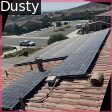

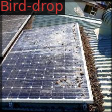

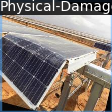

In [16]:
if setup_success:
    # Visualize some examples
    my_dataset_train_metadata = MetadataCatalog.get("my_dataset_train")
    dataset_dicts = DatasetCatalog.get("my_dataset_train")

    # Show random samples
    for d in random.sample(dataset_dicts, 3):
        img = cv2.imread(d["file_name"])
        visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
        vis = visualizer.draw_dataset_dict(d)
        cv2_imshow(vis.get_image()[:, :, ::-1])

In [ ]:
#visualize training data
my_dataset_train_metadata = MetadataCatalog.get("my_dataset_train")
dataset_dicts = DatasetCatalog.get("my_dataset_train")

import random
from detectron2.utils.visualizer import Visualizer

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

# Train Custom Detectron2 Detector

In [17]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0025  # pick a good LR
cfg.SOLVER.MAX_ITER = 500   # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 6  # (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=True)
trainer.train()

[01/28 11:55:48 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_280758.pkl: 167MB [00:00, 168MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[01/28 11:55:49 d2.engine.train_loop]: Starting training from iteration 0
ERROR [01/28 11:55:49 d2.engine.train_loop]: Exception during training:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py", line 155, in train
    self.run_step()
  File "/usr/local/lib/python3.11/dist-packages/detectron2/engine/defaults.py", line 530, in run_step
    self._trainer.run_step()
  File "/usr/local/lib/python3.11/dist-packages/detectron2/engine/train_loop.py", line 297, in run_step
    data = next(self._data_loader_iter)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/detectron2/data/common.py", line 329, in __iter__
    for d in self.dataset:
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 701, in __next__
    data = self._next_data()
           ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1465, in _n

SizeMismatchError: Caught SizeMismatchError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/worker.py", line 351, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/fetch.py", line 33, in fetch
    data.append(next(self.dataset_iter))
                ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/detectron2/data/common.py", line 296, in __iter__
    yield self.dataset[idx]
          ~~~~~~~~~~~~^^^^^
  File "/usr/local/lib/python3.11/dist-packages/detectron2/data/common.py", line 125, in __getitem__
    data = self._map_func(self._dataset[cur_idx])
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/detectron2/utils/serialize.py", line 26, in __call__
    return self._obj(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/detectron2/data/dataset_mapper.py", line 155, in __call__
    utils.check_image_size(dataset_dict, image)
  File "/usr/local/lib/python3.11/dist-packages/detectron2/data/detection_utils.py", line 197, in check_image_size
    raise SizeMismatchError(
detectron2.data.detection_utils.SizeMismatchError: Mismatched image shape for image /content/content/train/train_c3e52873-95b9-47ce-b7e0-c8391ca2c615_0.jpg, got (300, 200), expect (224, 224). Please check the width/height in your annotation.


In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

In [21]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = ("my_dataset_test", )
predictor = DefaultPredictor(cfg)

[01/28 09:48:01 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


/usr/local/lib/python3.11/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

# Inference with Detectron2 Saved Weights



In [22]:
test_metadata = MetadataCatalog.get("my_dataset_test")

In [ ]:
from detectron2.utils.visualizer import ColorMode
import glob

for imageName in glob.glob('/content/test/*jpg')[:3]:
  im = cv2.imread(imageName)
  outputs = predictor(im)
  v = Visualizer(im[:, :, ::-1],
                metadata=test_metadata,
                scale=0.8,
                instance_mode=ColorMode.IMAGE_BW
                 )
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  cv2_imshow(out.get_image()[:, :, ::-1])


# Evaluation

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
print("\nEvaluating model performance...")
evaluator = COCOEvaluator("my_dataset_test", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "my_dataset_test")
eval_results = inference_on_dataset(predictor.model, val_loader, evaluator)
print("\nEvaluation Results:", eval_results)

In [ ]:
# Save
print("\nSaving model configuration...")
with open('config.yml', 'w') as f:
    f.write(cfg.dump())
print("Configuration saved to config.yml")

In [25]:
# Additional Visualization of Results
def visualize_predictions(image_path, predictor, metadata):
    """
    Visualize predictions on a single image
    """
    im = cv2.imread(image_path)
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                  metadata=metadata,
                  scale=0.8,
                  instance_mode=ColorMode.IMAGE_BW)
    return v.draw_instance_predictions(outputs["instances"].to("cpu"))

# Show predictions for each class
print("\nVisualizing predictions for each class...")
test_images = glob.glob('./content/test/*.jpg')
for class_name in metadata.thing_classes:
    print(f"\nShowing predictions for class: {class_name}")
    # Find images of this class
    class_images = [img for img in test_images if class_name.lower() in img.lower()]
    if class_images:
        # Show first image of this class
        out = visualize_predictions(class_images[0], predictor, test_metadata)
        cv2_imshow(out.get_image()[:, :, ::-1])

# Print Final Training Summary
print("\nTraining Summary:")
print(f"Number of iterations: {cfg.SOLVER.MAX_ITER}")
print(f"Base learning rate: {cfg.SOLVER.BASE_LR}")
print(f"Batch size per image: {cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE}")
print(f"Number of classes: {cfg.MODEL.ROI_HEADS.NUM_CLASSES}")
print(f"Model saved to: {os.path.join(cfg.OUTPUT_DIR, 'model_final.pth')}")